# Programming Exercise 2: Logistic Regression

## 2.1 Logistic Regression: Predict whether a student gets admitted into university.
Suppose that you are the administrator of a university department and you want to determine each applicant's chance of admission based on their results on two exams. You have historical data from previous applicants that you can use as a training set for logistic regression. For each training example, you have: 
    1. the applicant's score for the first exam 
    2. the applicant's score for the second exam
    3. the admissions decision 

**Task**: Build a classification model that estimates an applicants _probability of admission_ based on the scores from the two exams. 

### 2.1.1 Data Visualization

<IPython.core.display.Javascript object>


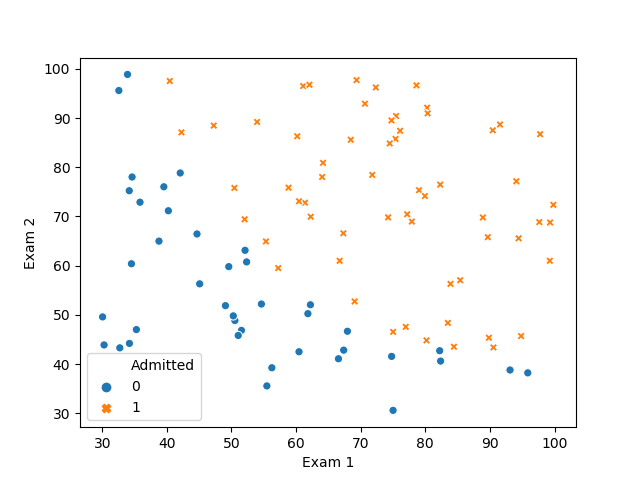

In [3]:
%matplotlib notebook 
import matplotlib.pyplot as plt 
import seaborn as sns 
import pandas as pd 

student_data = '../data/exercises/machine-learning-ex2/ex2/ex2data1.txt'
student_df = pd.read_csv(student_data, names = ['Exam 1', 'Exam 2', 'Admitted'], header=None)

sns.scatterplot(x = 'Exam 1', y = 'Exam 2', hue = 'Admitted', style='Admitted', data=student_df)

### 2.1.2 Implementation
#### 2.1.2.1 Warmup Exercise: Sigmoid Function

The hypothesis for logistic regression is: $h_\theta(x) = g(\theta^T x)$
where function $g$ is the standard logistic (or "sigmoid") function: $g(z) = \frac{1}{1 + e^{-z}}$

We will define a sigmoid function that works with vectors, matrices and scalars to be used by later parts of our logistic regression model.

In [12]:
import numpy as np
def sigmoid(z):
    return 1/(1 + np.exp(-z)) 

def test_sigmoid():
    # test scalar
    assert sigmoid(0) == 0.5
    
    # test vector
    test_vec = np.random.rand(3,1)
    sigmoid_vec = sigmoid(test_vec)
    assert sigmoid_vec.shape == (3,1)
    for i in range(0, len(test_vec)):
        assert sigmoid(test_vec[i]) == sigmoid_vec[i]

    # test matrix
    test_mat = np.random.rand(100, 24)
    sigmoid_mat = sigmoid(test_mat)
    assert sigmoid_mat.shape == (100,24)
    for row in range(0, test_mat.shape[0]):
        for col in range(0, test_mat.shape[1]):
            assert sigmoid(test_mat[row,col]) == sigmoid_mat[row,col]
test_sigmoid()

#### 2.1.2.2 Cost Function and Gradient

The cost function in logistic regression is the cross-entropy loss. We are maximizing the likelihood of the training set according to the *maximum likelihood estimator*:

$$ J(\theta) = \frac{1}{m} \sum_{i = 1}^{m}\Bigg[ -y^{(i)} \log\big(h_\theta(x^{(i)})\big) - (1 - y^{(i)}) \log\big(1 - h_\theta(x^{(i)})\big)\Bigg] $$

The gradient is defined as follows: 

$$ \frac{\partial J(\theta)}{\partial \theta_j} = \frac{1}{m} \sum_{i = 1}^{m} \Big( h_\theta(x^{(i)}) - y^{(i)}\Big) x_j^{(i)} $$

In [38]:
def hypothesis(theta: np.array, x: np.array): 
    z = x.dot(theta)  # m x n * n x 1 -> m x 1 array, one w^Tx for each example
    return sigmoid(z)

def cost_function(theta: np.array, X, y) -> float: 
    """
    Returns the loss of running the hypothesis on the training set with a set of given parameters.
    
    Parameters
    ----------
    theta : np.array
        
    
    Returns
    -------
    float
        Cost/training loss for a given set of parameters
    """
    h_x = hypothesis(theta, X)
    y = y.reshape(h_x.shape)
    m, n = X.shape  # number of training examples, number of features
    
    cost = np.sum((-y * np.log(h_x)) - ((1-y) * np.log(1 - h_x)))/m

    gradient_vec = (1/m) * X.T.dot(h_x - y)

    return cost


def test_cost_function():
    df = student_df.copy()
    X = np.c_[np.ones((df.shape[0],)), df[['Exam 1', 'Exam 2']].values]
    y = df['Admitted'].values
    m, n = X.shape
    initial_theta = np.zeros((n, 1))
    cost = cost_function(initial_theta, X, y)
    assert np.round(cost, 3) == 0.693

test_cost_function()


def gradient_function(theta, X, y) -> np.array:
    h_x = hypothesis(theta, X)
    y = y.reshape(h_x.shape)    
    m, n = X.shape  # number of training examples, number of features
    
#     gradient = np.zeros(theta.shape)
#     error = h_x - y
#     for j in range(0, n):
#         gradient[j] = np.sum((h_x - y) * X[:, j].reshape(-1,1))/m
        
    gradient_vec = (1/m) * X.T.dot(h_x - y)    
    return gradient_vec.reshape((n,))

#### 2.1.2.3 Learning Parameters through Gradient Descent

In [42]:
from scipy.optimize import minimize
df = student_df.copy()
X = np.c_[np.ones((df.shape[0],)), df[['Exam 1', 'Exam 2']].values]
y = df['Admitted'].values
m, n = X.shape
initial_theta = np.zeros((n, 1))

results = minimize(
    fun = cost_function,
    x0 = initial_theta,
    args = (X, y),
    method = 'BFGS',
    jac = gradient_function
)

C:\Users\edwin\anaconda3\envs\rl_env\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in log
C:\Users\edwin\anaconda3\envs\rl_env\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in multiply


In [43]:
results

      fun: 0.20349770158944383
 hess_inv: array([[ 3.31474479e+03, -2.63892205e+01, -2.70237122e+01],
       [-2.63892205e+01,  2.23869433e-01,  2.02682332e-01],
       [-2.70237122e+01,  2.02682332e-01,  2.35335117e-01]])
      jac: array([-9.52476827e-09, -9.31921322e-07, -2.82608934e-07])
  message: 'Optimization terminated successfully.'
     nfev: 31
      nit: 23
     njev: 31
   status: 0
  success: True
        x: array([-25.16133284,   0.2062317 ,   0.2014716 ])

#### 2.1.2.4 Evaluating Logistic Regression: Prediction

%% ============== Part 4: Predict and Accuracies ==============

After learning the parameters, you'll like to use it to predict the outcomes
on unseen data. In this part, you will use the logistic regression model
to predict the probability that a student with score 45 on exam 1 and 
score 85 on exam 2 will be admitted.


Furthermore, you will compute the training and test set accuracies of our model.

Predict probability for a student with score 45 on exam 1 and score 85 on exam 2 

prob = sigmoid([1 45 85] * theta);

fprintf(['For a student with scores 45 and 85, we predict an admission ' ...
         'probability of %f\n'], prob);
         
fprintf('Expected value: 0.775 +/- 0.002\n\n');

In [58]:
# Predict probability for a student with score 45 on exam 1 and score 85 on exam 2 
prob = sigmoid(results.x.dot([1,45,85]))
print(f"For a student with scores 45 and 85, we predict an admission probability of {prob:.3f}.")
print(f"Expected value: 0.775 +/- 0.002")

For a student with scores 45 and 85, we predict an admission probability of 0.776.
Expected value: 0.775 +/- 0.002


In [48]:
# Compute accuracy on our training set
predict = lambda theta, x: hypothesis(theta, x) >= 0.5
p = predict(results.x, X)
print(f"Train accuracy: {np.mean(p == y) * 100} %. Expected accuracy (approx.): 89.0")


Train accuracy: 89.0 %. Expected accuracy (approx.): 89.0


In [59]:
results.x

array([-25.16133284,   0.2062317 ,   0.2014716 ])

### Plot Decision Boundary

We define the decision boundary to be when $\theta^T x = 0$

For our resulting $\theta$ = [-25.161, 0.206, 0.201], $-25.161 x_0 + 0.206 x_1 + 0.201 x_2 = 0$

Since $x_0 = 1$, $$0.201 x_2 = 25.161 - 0.206 x_1$$, i.e., 

$$ \theta_2 x_2 = -\theta_0 - \theta_1 x_1$$

$$ x_2 = -\frac{1}{\theta_2} \big( \theta_0 + \theta_1 x_1 \big)$$
So to plot our decision boundary, we use: 
```
x_2 = -1/theta[2] * (theta[0] + theta[1] * x_1)
```


<IPython.core.display.Javascript object>


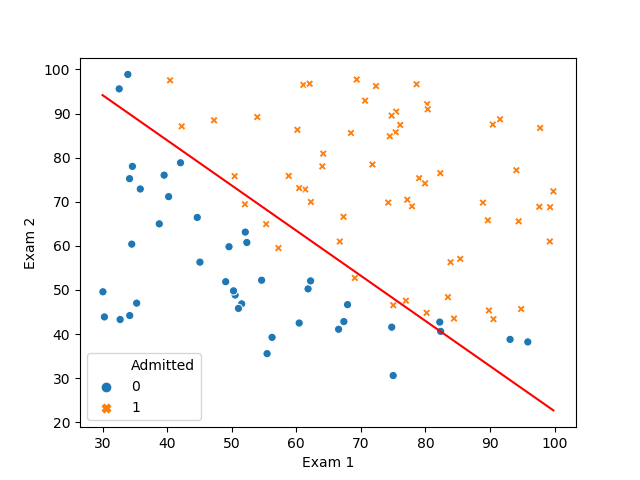

In [70]:
import matplotlib.pyplot as plt 

theta = results.x
x_min_max = np.array([30, np.max(X)])
y_min_max = -(1/theta[2]) * (theta[0] + theta[1] * x_min_max)

fig, ax = plt.subplots()
sns.scatterplot(x = 'Exam 1', y = 'Exam 2', hue = 'Admitted', style='Admitted', data=student_df, ax=ax)
plt.plot(x_min_max, y_min_max, color='red')